# Appendix plots

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from utils import breaklines
from DataHandler import DataHandler
from Tree import Tree
from PWPolyTree_MIP import PieceWisePolyTree_MIP

In [2]:
n_features = 2
val_range = 100 # range of values of features [-val_range, val_range]
n_data = 250    # samples used for the MIP solve
n_sample = 1000 # sample for the ground truth visualization
time_limit = 300

def ground_truth(sample):
    return sum(abs(sample))

np.random.seed(0)
X = np.random.uniform(-val_range, val_range, (n_data, n_features))
y = np.array([ground_truth(x) for x in X])

dh = DataHandler(None, direct_data=(X, y, None, [f"x{i}" for i in range(n_features)], "Direct_data"))
X_train, y_train = dh.get_training_data(test_size=0)

pwptree = PieceWisePolyTree_MIP(2, dh, poly_order=1)
pwptreel = PieceWisePolyTree_MIP(2, dh, poly_order=1, axis_aligned=False)

pwptree.make_model(X_train, y_train)
pwptreel.make_model(X_train, y_train)

pwptree.optimize(time_limit=time_limit)
pwptreel.optimize(time_limit=time_limit)
ctx = pwptree.get_base_context()
ctxl = pwptreel.get_base_context()
(ctx["status"], ctxl["status"])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


('OPT', 'TIME')

/home/epanemu/Work/picewise_poly_trees/submission_files/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  x_vals = (b[i] - a[1, i] * lims_y) / a[0, i]
/home/epanemu/Work/picewise_poly_trees/submission_files/utils.py:69: RuntimeWarning: divide by zero encountered in divide
  y_vals = (b[i] - a[0, i] * lims_x) / a[1, i]


9.79e-05 +-0.000942 max:0.022 median: 3.04e-05
\scinum{0.022015681793301364} & \scinum{9.788552931962676e-05} & \scinum{3.0399942109511357e-05}
0.000111 +-0.00107 max:0.026 median: 3.04e-05
\scinum{0.02604307023189877} & \scinum{0.00011084159563612121} & \scinum{3.0358761727917738e-05}


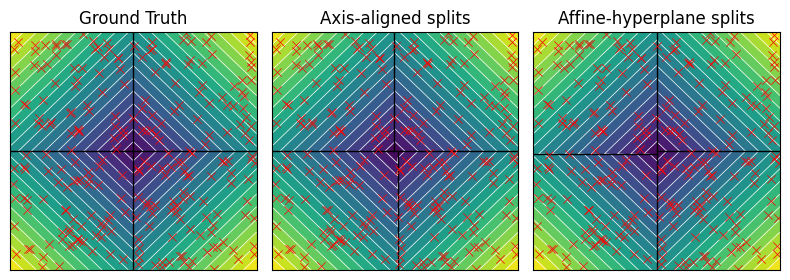

In [3]:
tree = Tree(ctx, dh)
treel = Tree(ctxl, dh)

x1, x2 = np.meshgrid(np.linspace(-val_range, val_range, n_sample), np.linspace(-val_range, val_range, n_sample))
gt = np.zeros_like(x1)
for i in range(1000):
    for j in range(1000):
        gt[i,j] = ground_truth(np.array([x1[i,j], x2[i,j]]))

X_space = np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1)

X_leaf = tree.get_assignment(X_space)
X_leafl = treel.get_assignment(X_space)

expo = pwptree.get_exponents(n_features)
leaf_values = dh.unnormalize_y(dh.normalize(X_space) @ expo @ ctx["poly_coeffs"] + ctx["intercepts"])
leaf_valuesl = dh.unnormalize_y(dh.normalize(X_space) @ expo @ ctxl["poly_coeffs"] + ctxl["intercepts"])

computed_vals = leaf_values[range(leaf_values.shape[0]), X_leaf].reshape((n_sample, n_sample))
computed_valsl = leaf_valuesl[range(leaf_valuesl.shape[0]), X_leafl].reshape((n_sample, n_sample))

vmin = min(computed_vals.min(), computed_valsl.min(), gt.min())
vmax = max(computed_vals.max(), computed_valsl.max(), gt.max())

contours = np.linspace(vmin, vmax, 20)

fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize=(8,2.9))
cf = ax.contourf(x1, x2, gt, contours, vmin=vmin, vmax=vmax, zorder=0)
ax.contour(x1, x2, gt, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in [[[-val_range,0], [val_range,0]], [[0,-val_range], [0,val_range]]]:
    ax.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax.set_title("Ground Truth")

cf2 = ax2.contourf(x1, x2, computed_vals, contours, vmin=vmin, vmax=vmax, zorder=0)
ax2.contour(x1, x2, computed_vals, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in breaklines(dh, tree, ctx, val_range):
    ax2.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax2.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax2.set_title("Axis-aligned splits")

cf3 = ax3.contourf(x1, x2, computed_valsl, contours, vmin=vmin, vmax=vmax, zorder=0)
ax3.contour(x1, x2, computed_valsl, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in breaklines(dh, treel, ctxl, val_range):
    ax3.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax3.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax3.set_title("Affine-hyperplane splits")

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax3.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig("norm1.png", dpi=300)

rel_diff1 = np.abs(gt - computed_vals).flatten() / np.abs(gt).max()
print(f"{rel_diff1.mean():.3g} +-{rel_diff1.std():.3g} max:{rel_diff1.max():.3g} median: {np.median(rel_diff1):.3g}")
print(f"\\scinum{{{rel_diff1.max()}}} & \\scinum{{{rel_diff1.mean()}}} & \\scinum{{{np.median(rel_diff1)}}}")

rel_diff2 = np.abs(gt - computed_valsl).flatten() / np.abs(gt).max()
print(f"{rel_diff2.mean():.3g} +-{rel_diff2.std():.3g} max:{rel_diff2.max():.3g} median: {np.median(rel_diff2):.3g}")
print(f"\\scinum{{{rel_diff2.max()}}} & \\scinum{{{rel_diff2.mean()}}} & \\scinum{{{np.median(rel_diff2)}}}")

In [4]:
n_features = 2
val_range = 100 # range of values of features [-val_range, val_range]
n_data = 250    # samples used for the MIP solve
n_sample = 1000 # sample for the ground truth visualization
time_limit = 300

def ground_truth(sample):
    return max(abs(sample))

np.random.seed(0)
X = np.random.uniform(-val_range, val_range, (n_data, n_features))
y = np.array([ground_truth(x) for x in X])

dh = DataHandler(None, direct_data=(X, y, None, [f"x{i}" for i in range(n_features)], "Direct_data"))
X_train, y_train = dh.get_training_data(test_size=0)

pwptree = PieceWisePolyTree_MIP(2, dh, poly_order=1)
pwptreel = PieceWisePolyTree_MIP(2, dh, poly_order=1, axis_aligned=False)

pwptree.make_model(X_train, y_train)
pwptreel.make_model(X_train, y_train)

pwptree.optimize(time_limit=time_limit)
pwptreel.optimize(time_limit=time_limit)
ctx = pwptree.get_base_context()
ctxl = pwptreel.get_base_context()
(ctx["status"], ctxl["status"])

('OPT', 'TIME')

0.0851 +-0.117 max:0.719 median: 0.0282
\scinum{0.7186999470693821} & \scinum{0.08506899722574107} & \scinum{0.028201825194180685}
0.000422 +-0.00301 max:0.066 median: 5.05e-05
\scinum{0.06604959284704932} & \scinum{0.0004217446020628828} & \scinum{5.04670190798251e-05}


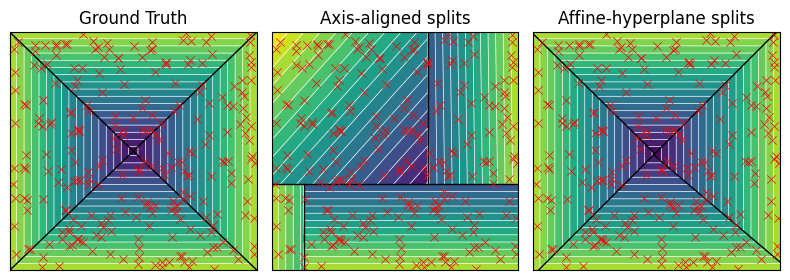

In [5]:
tree = Tree(ctx, dh)
treel = Tree(ctxl, dh)

x1, x2 = np.meshgrid(np.linspace(-val_range, val_range, n_sample), np.linspace(-val_range, val_range, n_sample))
gt = np.zeros_like(x1)
for i in range(1000):
    for j in range(1000):
        gt[i,j] = ground_truth(np.array([x1[i,j], x2[i,j]]))

X_space = np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1)

X_leaf = tree.get_assignment(X_space)
X_leafl = treel.get_assignment(X_space)

expo = pwptree.get_exponents(n_features)
leaf_values = dh.unnormalize_y(dh.normalize(X_space) @ expo @ ctx["poly_coeffs"] + ctx["intercepts"])
leaf_valuesl = dh.unnormalize_y(dh.normalize(X_space) @ expo @ ctxl["poly_coeffs"] + ctxl["intercepts"])

computed_vals = leaf_values[range(leaf_values.shape[0]), X_leaf].reshape((n_sample, n_sample))
computed_valsl = leaf_valuesl[range(leaf_valuesl.shape[0]), X_leafl].reshape((n_sample, n_sample))

vmin = min(computed_vals.min(), computed_valsl.min(), gt.min())
vmax = max(computed_vals.max(), computed_valsl.max(), gt.max())

contours = np.linspace(vmin, vmax, 20)

fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize=(8,2.9))
cf = ax.contourf(x1, x2, gt, contours, vmin=vmin, vmax=vmax, zorder=0)
ax.contour(x1, x2, gt, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in [[[-val_range,val_range], [val_range,-val_range]], [[-val_range,-val_range], [val_range,val_range]]]:
    ax.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax.set_title("Ground Truth")

cf2 = ax2.contourf(x1, x2, computed_vals, contours, vmin=vmin, vmax=vmax, zorder=0)
ax2.contour(x1, x2, computed_vals, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in breaklines(dh, tree, ctx, val_range):
    ax2.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax2.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax2.set_title("Axis-aligned splits")

cf3 = ax3.contourf(x1, x2, computed_valsl, contours, vmin=vmin, vmax=vmax, zorder=0)
ax3.contour(x1, x2, computed_valsl, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in breaklines(dh, treel, ctxl, val_range):
    ax3.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax3.scatter(dh.unnormalize(X_train)[:,0], dh.unnormalize(X_train)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax3.set_title("Affine-hyperplane splits")

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax3.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig("norminf.png", dpi=300)

rel_diff1 = np.abs(gt - computed_vals).flatten() / np.abs(gt).max()
print(f"{rel_diff1.mean():.3g} +-{rel_diff1.std():.3g} max:{rel_diff1.max():.3g} median: {np.median(rel_diff1):.3g}")
print(f"\\scinum{{{rel_diff1.max()}}} & \\scinum{{{rel_diff1.mean()}}} & \\scinum{{{np.median(rel_diff1)}}}")

rel_diff2 = np.abs(gt - computed_valsl).flatten() / np.abs(gt).max()
print(f"{rel_diff2.mean():.3g} +-{rel_diff2.std():.3g} max:{rel_diff2.max():.3g} median: {np.median(rel_diff2):.3g}")
print(f"\\scinum{{{rel_diff2.max()}}} & \\scinum{{{rel_diff2.mean()}}} & \\scinum{{{np.median(rel_diff2)}}}")

# Neural network with ReLU activations only

In [6]:
import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


class NNModel:
    def __init__(self, input_size, hidden_sizes, output_size):
        layers = []
        prev_size = input_size
        for curr_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, curr_size))
            layers.append(nn.ReLU())
            prev_size = curr_size
        layers.append(nn.Linear(prev_size, output_size))
        # no ReLU on the output
        self.layers = layers

        self.model = nn.Sequential(*layers)

        self.loss_f = nn.MSELoss()

        self.optimizer = torch.optim.AdamW(self.model.parameters())

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            res = self.model(x)
        return res.numpy()

    def train(self, X_train, y_train, epochs=50, batch_size=64):
        dataset = SimpleDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        print("Training:")
        self.model.train()
        for j in tqdm(range(epochs)):
            for i, (X, y) in enumerate(dataloader):
                y_pred = self.model(X)

                loss = self.loss_f(y_pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def test(self, X_test, y_test):
        dataset = SimpleDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        print("Testing:")
        self.model.eval()
        losses = []
        with torch.no_grad():
            for i, (X, y) in enumerate(dataloader):
                y_pred = self.model(X)
                losses.append(self.loss_f(y_pred, y).item())
        print("Average loss:", sum(losses) / y_test.shape[0])

n_features = 2
val_range = 2 # range of values of features [-val_range, val_range]
n_data = 10    # samples used for the NN
n_sample = 1000 # sample for the ground truth visualization

def ground_truth(sample):
    return 2*np.sin(sample[0]) + 2*np.cos(sample[1]) + sample[1]/val_range

np.random.seed(0)
X = np.random.uniform(-val_range, val_range, (n_data, n_features))
y = np.array([ground_truth(x) for x in X]) + np.random.normal(0, 0.1, (n_data,))

dh = DataHandler(None, direct_data=(X, y, None, [f"x{i}" for i in range(n_features)], "Direct_data"))
X_train, y_train = dh.get_training_data(test_size=0)

torch.random.manual_seed(42)
nn_model = NNModel(2, [4,2], 1)
nn_model.train(X_train, y_train, batch_size=n_data, epochs=5000)
nn_model.test(X_train, y_train)

Training:


100%|██████████| 5000/5000 [00:06<00:00, 779.75it/s]

Testing:
Average loss: 0.00455832473380724


In [7]:
[list(nn_model.layers[i].parameters()) for i in [0,2,4]]

[[Parameter containing:
  tensor([[ 1.3902,  0.5876],
          [ 0.5053,  0.9266],
          [-0.4898, -0.0257],
          [ 0.1677,  0.5433]], requires_grad=True),
  Parameter containing:
  tensor([ 0.7071, -0.8178,  0.5257,  0.2919], requires_grad=True)],
 [Parameter containing:
  tensor([[ 0.2788, -0.4557,  0.0382, -0.2823],
          [ 0.6600, -0.9858, -0.3215,  0.2567]], requires_grad=True),
  Parameter containing:
  tensor([-0.3386,  0.0613], requires_grad=True)],
 [Parameter containing:
  tensor([[-0.2982,  0.8477]], requires_grad=True),
  Parameter containing:
  tensor([-0.4105], requires_grad=True)]]

In [8]:
# partitioning computed separately from NN parameters that are fixed due to manual seed
def NN_points():
     return np.array([[[0.4104817137390428, 0.1795520315659713], [-2.0, 1.3476204332837263]],
                      [[0.4104817137390428, 0.1795520315659713], [0.4832792607179929, -2.0]],
                      [[2.0, -0.5906948753288315], [0.4104817137390428, 0.1795520315659713]],
                      [[1.9140468351725994, 2.0], [2.0, 0.5494942280968885]],
                      [[0.4104817137390428, 0.17955203156597127], [2.0, 0.49137342498169767]]])

In [9]:
n_tree_samples_w = 15
n_tree_samples = n_tree_samples_w*n_tree_samples_w
x1, x2 = np.meshgrid(np.linspace(-val_range, val_range, n_tree_samples_w), np.linspace(-val_range, val_range, n_tree_samples_w))

gt = np.zeros_like(x1)
for i in range(n_tree_samples_w):
    for j in range(n_tree_samples_w):
        gt[i,j] = ground_truth(np.array([x1[i,j], x2[i,j]]))

NNspace = dh.normalize(np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1))
nn_vals = nn_model.predict(NNspace)

In [10]:
time_limit = 300
dh.set_n_data(n_tree_samples) # this is needed to have the correct parameters in the MIP formulation
pwptree = PieceWisePolyTree_MIP(2, dh, poly_order=1, axis_aligned=False)

pwptree.make_model(NNspace, nn_vals)

pwptree.optimize(time_limit=time_limit)
print(pwptree.get_humanlike_status())
ctx = pwptree.get_base_context()
ctx["status"]

Only perform if you know what you are doing


TIME


'TIME'

0.00018 +-0.00147 max:0.0301 median: 2.69e-07
\scinum{0.030146090044253088} & \scinum{0.00017965119982446732} & \scinum{2.686642996129214e-07}


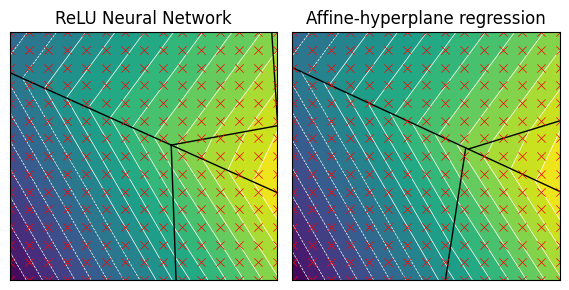

In [11]:
x1, x2 = np.meshgrid(np.linspace(-val_range, val_range, n_sample), np.linspace(-val_range, val_range, n_sample))
gt = np.zeros_like(x1)
for i in range(n_sample):
    for j in range(n_sample):
        gt[i,j] = ground_truth(np.array([x1[i,j], x2[i,j]]))

X_space = np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1)

nn_visualize = dh.unnormalize_y(nn_model.predict(dh.normalize(X_space))).reshape((n_sample, n_sample))

tree = Tree(ctx, dh)
X_leaf = tree.get_assignment(X_space)

expo = pwptree.get_exponents(n_features)
leaf_values = dh.unnormalize_y(dh.normalize(X_space) @ expo @ ctx["poly_coeffs"] + ctx["intercepts"])

computed_vals = leaf_values[range(leaf_values.shape[0]), X_leaf].reshape((n_sample, n_sample))

vmin = min(computed_vals.min(), nn_visualize.min())
vmax = max(computed_vals.max(), nn_visualize.max())

contours = np.linspace(vmin, vmax, 20)

fig, [ax, ax2] = plt.subplots(1, 2, figsize=(5.8,3))
cf = ax.contourf(x1, x2, nn_visualize, contours, vmin=vmin, vmax=vmax, zorder=0)
ax.contour(x1, x2, nn_visualize, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in NN_points():
    ax.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax.scatter(dh.unnormalize(NNspace)[:,0], dh.unnormalize(NNspace)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax.set_title("ReLU Neural Network")

cf2 = ax2.contourf(x1, x2, computed_vals, contours, vmin=vmin, vmax=vmax, zorder=0)
ax2.contour(x1, x2, computed_vals, contours, colors="w", linewidths=0.5, zorder=0.25)
for p1, p2 in breaklines(dh, tree, ctx, val_range):
    ax2.plot([p1[0], p2[0]],[p1[1], p2[1]], color="black", linewidth=1, zorder=0.5)
ax2.scatter(dh.unnormalize(NNspace)[:,0], dh.unnormalize(NNspace)[:,1], color="red", marker="x", zorder=1, linewidths=0.5)
ax2.set_title("Affine-hyperplane regression")

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)


plt.tight_layout()
plt.savefig("NN_relu.png")


rel_diff1 = np.abs(nn_visualize - computed_vals).flatten() / np.abs(nn_visualize).max()
print(f"{rel_diff1.mean():.3g} +-{rel_diff1.std():.3g} max:{rel_diff1.max():.3g} median: {np.median(rel_diff1):.3g}")
print(f"\\scinum{{{rel_diff1.max()}}} & \\scinum{{{rel_diff1.mean()}}} & \\scinum{{{np.median(rel_diff1)}}}")

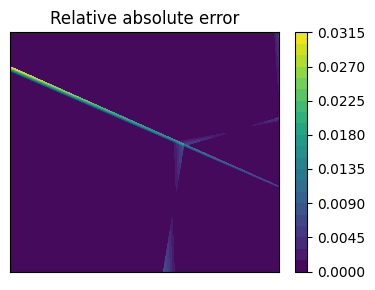

In [12]:

# fig, ax = plt.subplots(1, 1, figsize=(3,3))
fig, ax = plt.subplots(1, 1, figsize=(3.9,3))
cf = ax.contourf(x1, x2, np.abs(nn_visualize-computed_vals)/nn_visualize.max(), 20, zorder=0)
ax.set_title("Relative absolute error")

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.colorbar(cf, ax=ax)


plt.tight_layout()
# plt.savefig("NN_relu_err.png")
plt.savefig("NN_relu_err_bar.png")